# Statystyka praktyczna w data science (Python)
# Rozdział 5. Klasyfikacja
> (c) 2019 Peter C. Bruce, Andrew Bruce, Peter Gedeck

Importuje wymagane pakiety Pythona.

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression #, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score

import statsmodels.api as sm

from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from pygam import LinearGAM, s, f, l


from dmba import classificationSummary

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline


DATA = Path('.').resolve().parents[0] / 'dane'

ModuleNotFoundError: No module named 'imblearn'

Definiuje ścieżki do zestawów danych. Jeżeli przechowujesz dane w innym katalogu, wprowadź poniżej stosowne zmiany.

In [ ]:
LOAN3000_CSV = DATA / 'loan3000.csv'
LOAN_DATA_CSV = DATA / 'loan_data.csv.gz'
FULL_TRAIN_SET_CSV = DATA / 'full_train_set.csv.gz'

# Naiwny klasyfikator bayesowski
## Rozwiązanie naiwne

In [ ]:
loan_data = pd.read_csv(LOAN_DATA_CSV)

# przekształca w zmienne skategoryzowane
loan_data.outcome = loan_data.outcome.astype('category')
loan_data.outcome.cat.reorder_categories(['paid off', 'default'])
loan_data.purpose_ = loan_data.purpose_.astype('category')
loan_data.home_ = loan_data.home_.astype('category')
loan_data.emp_len_ = loan_data.emp_len_.astype('category')

predictors = ['purpose_', 'home_', 'emp_len_']
outcome = 'outcome'
X = pd.get_dummies(loan_data[predictors], prefix='', prefix_sep='')
y = loan_data[outcome]

naive_model = MultinomialNB(alpha=0.01, fit_prior=True)
naive_model.fit(X, y)

new_loan = X.loc[146:146, :] 
print('Przewidywana klasa: ', naive_model.predict(new_loan)[0])

probabilities = pd.DataFrame(naive_model.predict_proba(new_loan),
                             columns=naive_model.classes_)
print('Przewidywane prawdopodobieństwa',)
print(probabilities)

Przewidywana klasa:  default
Przewidywane prawdopodobieństwa
    default  paid off
0  0.653696  0.346304


### Przykład niezawarty w książce

Zmienne numeryczne nie są obsługiwane przez pakiet scikit-learn. W przykładzie tym demonstrowane jest dzielenie zmiennej na przedziały i wyświetlanie rozkładu prawdopodobieństwa przedziałów.
```
## Przykład niedostępny w książce
less_naive <- NaiveBayes(outcome ~ borrower_score + payment_inc_ratio + 
                           purpose_ + home_ + emp_len_, data = loan_data)
less_naive$table[1:2]

png(filename=file.path(PSDS_PATH, 'figures', 'psds_naive_bayes.png'),  width = 4, height=3, units='in', res=300)

stats <- less_naive$table[[1]]
ggplot(data.frame(borrower_score=c(0,1)), aes(borrower_score)) +
  stat_function(fun = dnorm, color='blue', linetype=1, 
                arg=list(mean=stats[1, 1], sd=stats[1, 2])) +
  stat_function(fun = dnorm, color='red', linetype=2, 
                arg=list(mean=stats[2, 1], sd=stats[2, 2])) +
  labs(y='Prawdopodobieństwo')
dev.off()
```

# Analiza dyskryminacyjna
## Prosty przykład

In [ ]:
loan3000 = pd.read_csv(LOAN3000_CSV)
loan3000.outcome = loan3000.outcome.astype('category')

predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

loan_lda = LinearDiscriminantAnalysis()
loan_lda.fit(X, y)
print(pd.DataFrame(loan_lda.scalings_, index=X.columns))

                          0
borrower_score     7.175839
payment_inc_ratio -0.099676


In [ ]:
pred = pd.DataFrame(loan_lda.predict_proba(loan3000[predictors]),
                    columns=loan_lda.classes_)
print(pred.head())

    default  paid off
0  0.553544  0.446456
1  0.558953  0.441047
2  0.272696  0.727304
3  0.506254  0.493746
4  0.609952  0.390048


### Rysunek 5.1

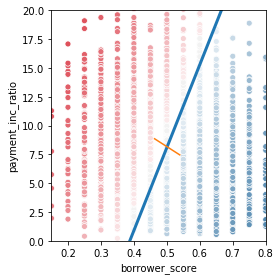

In [ ]:
# Granice decyzyjne zostają określone za pomocą skalowania i środka średnich
center = np.mean(loan_lda.means_, axis=0)
slope = - loan_lda.scalings_[0] / loan_lda.scalings_[1]
intercept = center[1] - center[0] * slope

# Wartości payment_inc_ratio dla borrower_score w punktach 0 i 20
x_0 = (0 - intercept) / slope
x_20 = (20 - intercept) / slope

lda_df = pd.concat([loan3000, pred['default']], axis=1)
lda_df.head()

fig, ax = plt.subplots(figsize=(4, 4))
g = sns.scatterplot(x='borrower_score', y='payment_inc_ratio',
                    hue='default', data=lda_df, 
                    palette=sns.diverging_palette(240, 10, n=9, as_cmap=True),
                    ax=ax, legend=False)

ax.set_ylim(0, 20)
ax.set_xlim(0.15, 0.8)
ax.plot((x_0, x_20), (0, 20), linewidth=3)
ax.plot(*loan_lda.means_.transpose())

plt.tight_layout()
plt.show()

# Regresja logistyczna
## Funkcja odpowiedzi logistycznej i logit

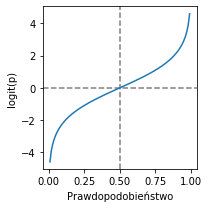

In [ ]:
p = np.arange(0.01, 1, 0.01)
df = pd.DataFrame({
    'p': p,
    'logit': np.log(p / (1 - p)),
    'odds': p / (1 - p),
})

fig, ax = plt.subplots(figsize=(3, 3))
ax.axhline(0, color='grey', linestyle='--')
ax.axvline(0.5, color='grey', linestyle='--')
ax.plot(df['p'], df['logit'])
ax.set_xlabel('Prawdopodobieństwo')
ax.set_ylabel('logit(p)')

plt.tight_layout()
plt.show()

## Regresja logistyczna i GLM
Pakiet _scikit-learn_ zawiera wyspecjalizowaną klasę dla modeli `LogisticRegression`. Pakiet _Statsmodels_ zawiera ogólniejszą metodę bazującą na uogólnionym modelu liniowym (GLM).

In [ ]:
predictors = ['payment_inc_ratio', 'purpose_', 'home_', 'emp_len_', 
              'borrower_score']
outcome = 'outcome'
X = pd.get_dummies(loan_data[predictors], prefix='', prefix_sep='', 
                   drop_first=True)
y = loan_data[outcome] # .cat.categories

logit_reg = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
logit_reg.fit(X, y)

print('Wyraz wolny ', logit_reg.intercept_[0])
print('Klasy', logit_reg.classes_)
pd.DataFrame({'Współczynnik': logit_reg.coef_[0]}, 
             index=X.columns)

Wyraz wolny  -1.6378909367783945
Klasy ['default' 'paid off']


,Współczynnik
payment_inc_ratio,-0.079739
borrower_score,4.612184
debt_consolidation,-0.249414
home_improvement,-0.407734
major_purchase,-0.229709
medical,-0.510744
other,-0.620800
small_business,-1.214936
OWN,-0.048211
RENT,-0.157288


Zwróć uwagę, że wyraz wolny i współczynniki są odwrócone w porównaniu do modelu R.

In [ ]:
print(loan_data['purpose_'].cat.categories)
print(loan_data['home_'].cat.categories)
print(loan_data['emp_len_'].cat.categories)

Index(['credit_card', 'debt_consolidation', 'home_improvement',
       'major_purchase', 'medical', 'other', 'small_business'],
      dtype='object')
Index(['MORTGAGE', 'OWN', 'RENT'], dtype='object')
Index([' < 1 Year', ' > 1 Year'], dtype='object')


_Informacje dodatkowe_ :
Jeżeli dysponujesz porządkową cechą lub zmienną wyniku, skorzystaj z dostępnej w pakiecie scikit-learn metody `OrdinalEncoder`, aby zastąpić kategorie ( 'paid off' i 'default') wartościami liczbowymi. W poniższym listingu zastępujemy kategorię 'paid off' wartością 0, a 'default' jedynką. Rozwiązanie to odwraca kolejność przewidywanych klas i, w konsekwencji, współczynników. 

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder(categories=[['paid off', 'default']])
y_enc = enc.fit_transform(loan_data[[outcome]]).ravel()

logit_reg_enc = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg_enc.fit(X, y_enc)

print('Wyraz wolny ', logit_reg_enc.intercept_[0])
print('Klasy', logit_reg_enc.classes_)
pd.DataFrame({'Współczynnik': logit_reg_enc.coef_[0]}, 
             index=X.columns)

Wyraz wolny  1.637890859199969
Klasy [0. 1.]


,Współczynnik
payment_inc_ratio,0.079739
borrower_score,-4.612183
debt_consolidation,0.249414
home_improvement,0.407734
major_purchase,0.229710
medical,0.510744
other,0.620800
small_business,1.214936
OWN,0.048211
RENT,0.157288


## Wartości prognozowane na podstawie regresji logistycznej

In [ ]:
pred = pd.DataFrame(logit_reg.predict_log_proba(X),
                    columns=logit_reg.classes_)
print(pred.describe())

            default      paid off
count  45342.000000  45342.000000
mean      -0.757872     -0.760434
std        0.378093      0.390456
min       -2.769376     -3.538593
25%       -0.985739     -0.977207
50%       -0.697406     -0.688907
75%       -0.472183     -0.467069
max       -0.029485     -0.064753


In [ ]:
pred = pd.DataFrame(logit_reg.predict_proba(X),
                    columns=logit_reg.classes_)
print(pred.describe())

            default      paid off
count  45342.000000  45342.000000
mean       0.500000      0.500000
std        0.167354      0.167354
min        0.062701      0.029054
25%        0.373163      0.376361
50%        0.497875      0.502125
75%        0.623639      0.626837
max        0.970946      0.937299


## Interpretacja współczynników i iloraz szans

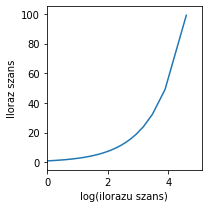

In [ ]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.plot(df['logit'], df['odds'])
ax.set_xlabel('log(ilorazu szans)')
ax.set_ylabel('Iloraz szans')
ax.set_xlim(0, 5.1)
ax.set_ylim(-5, 105)

plt.tight_layout()
plt.show()

## Ocena modelu
Dla porównania widzimy tu model GLM uzyskany za pomocą klasy _statsmodels_. Metoda ta wymaga, aby wynik był mapowany na wartości liczbowe.

In [ ]:
# wykorzystuje uogólniony model liniowy (GLM) w wersji dwumianowej w celu dopasowania regresji logistycznej
y_numbers = [1 if yi == 'default' else 0 for yi in y]
logit_reg_sm = sm.GLM(y_numbers, X.assign(const=1), 
                      family=sm.families.Binomial())
logit_result = logit_reg_sm.fit()
print(logit_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                45342
Model:                            GLM   Df Residuals:                    45330
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -28757.
Date:                Thu, 12 Nov 2020   Deviance:                       57515.
Time:                        12:33:27   Pearson chi2:                 4.54e+04
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
payment_inc_ratio      0.0797      0

Wykorzystujemy funkcje sklejane:

In [ ]:
import statsmodels.formula.api as smf
formula = ('outcome ~ bs(payment_inc_ratio, df=8) + purpose_ + ' +
           'home_ + emp_len_ + bs(borrower_score, df=3)')
model = smf.glm(formula=formula, data=loan_data, family=sm.families.Binomial())
results = model.fit()
print(results.summary())

                             Generalized Linear Model Regression Results                             
Dep. Variable:     ['outcome[default]', 'outcome[paid off]']   No. Observations:                45342
Model:                                                   GLM   Df Residuals:                    45321
Model Family:                                       Binomial   Df Model:                           20
Link Function:                                         logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -28731.
Date:                                       Thu, 12 Nov 2020   Deviance:                       57462.
Time:                                               12:33:48   Pearson chi2:                 4.54e+04
No. Iterations:                                            6                                         
Covariance Type:                                   nonrobust                      

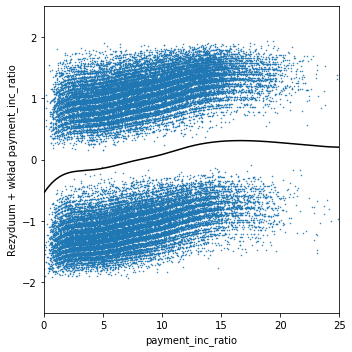

In [ ]:
from statsmodels.genmod.generalized_linear_model import GLMResults
def partialResidualPlot(model, df, outcome, feature, fig, ax):
    y_actual = [0 if s == 'default' else 1 for s in df[outcome]]
    y_pred = model.predict(df)
    org_params = model.params.copy()
    zero_params = model.params.copy()
    # wyznacza wartość 0 pozostałych cech parametró modelu
    for i, name in enumerate(zero_params.index):
        if feature in name:
            continue
        zero_params[i] = 0.0
    model.initialize(model.model, zero_params)
    feature_prediction = model.predict(df)
    ypartial = -np.log(1/feature_prediction - 1)
    ypartial = ypartial - np.mean(ypartial)
    model.initialize(model.model, org_params)
    results = pd.DataFrame({
        'feature': df[feature],
        'residual': -2 * (y_actual - y_pred),
        'ypartial': ypartial/ 2,
    })
    results = results.sort_values(by=['feature'])

    ax.scatter(results.feature, results.residual, marker=".", s=72./fig.dpi)
    ax.plot(results.feature, results.ypartial, color='black')
    ax.set_xlabel(feature)
    ax.set_ylabel(f'Rezyduum + wkład {feature}')
    return ax

fig, ax = plt.subplots(figsize=(5, 5))
partialResidualPlot(results, loan_data, 'outcome', 'payment_inc_ratio', fig, ax)
ax.set_xlim(0, 25)
ax.set_ylim(-2.5, 2.5)


plt.tight_layout()
plt.show()

# Ewaluacja modeli klasyfikacji
## Macierz błędów

In [ ]:
# Macierz błędów
pred = logit_reg.predict(X)
pred_y = logit_reg.predict(X) == 'default'
true_y = y == 'default'
true_pos = true_y & pred_y
true_neg = ~true_y & ~pred_y
false_pos = ~true_y & pred_y
false_neg = true_y & ~pred_y

conf_mat = pd.DataFrame([[np.sum(true_pos), np.sum(false_neg)], [np.sum(false_pos), np.sum(true_neg)]],
                       index=['Y = default', 'Y = paid off'],
                       columns=['Yhat = default', 'Yhat = paid off'])
print(conf_mat)

              Yhat = default  Yhat = paid off
Y = default            14337             8334
Y = paid off            8149            14522


In [ ]:
print(confusion_matrix(y, logit_reg.predict(X)))

[[14337  8334]
 [ 8149 14522]]


Pakiet _dmba_ zawiera funkcję `classificationSummary` wyświetlającą macierz błędów i dokładność modelu klasyfikującego.

In [ ]:
classificationSummary(y, logit_reg.predict(X), 
                      class_names=logit_reg.classes_)

Confusion Matrix (Accuracy 0.6365)

         Prediction
  Actual  default paid off
 default    14337     8334
paid off     8149    14522


## Precyzja, czułość i swoistość
Funkcja `precision_recall_fscore_support` z pakietu _scikit-learn_ zwraca precyzję, czułość, fbeta_score i nośnik (ang. support). 

In [ ]:
conf_mat = confusion_matrix(y, logit_reg.predict(X))
print('Precyzja', conf_mat[0, 0] / sum(conf_mat[:, 0]))
print('Czułość', conf_mat[0, 0] / sum(conf_mat[0, :]))
print('Swoistość', conf_mat[1, 1] / sum(conf_mat[1, :]))

Precyzja 0.6375967268522637
Czułość 0.6323938070662961
Swoistość 0.640554011733051


In [ ]:
precision_recall_fscore_support(y, logit_reg.predict(X), 
                                labels=['default', 'paid off'])

(array([0.63759673, 0.63536927]),
 array([0.63239381, 0.64055401]),
 array([0.63498461, 0.63795111]),
 array([22671, 22671], dtype=int64))

## Krzywa ROC
Funkcja `roc_curve` z pakietu _Scikit-learn_ oblicza wszystkie informacje wymagane do utworzenia wykresu ROC.

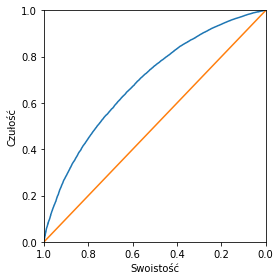

In [ ]:
fpr, tpr, thresholds = roc_curve(y, logit_reg.predict_proba(X)[:, 0], 
                                 pos_label='default')
roc_df = pd.DataFrame({'recall': tpr, 'specificity': 1 - fpr})

ax = roc_df.plot(x='specificity', y='recall', figsize=(4, 4), legend=False)
ax.set_ylim(0, 1)
ax.set_xlim(1, 0)
ax.plot((1, 0), (0, 1))
ax.set_xlabel('Swoistość')
ax.set_ylabel('Czułość')


plt.tight_layout()
plt.show()

## Pole pod wykresem krzywej ROC
Można łatwo obliczyć dokładność za pomocą funkcji `accuracy_score`.

In [ ]:
print(np.sum(roc_df.recall[:-1] * np.diff(1 - roc_df.specificity)))
print(roc_auc_score([1 if yi == 'default' else 0 for yi in y], logit_reg.predict_proba(X)[:, 0]))

0.691710717463757
0.691710795288669


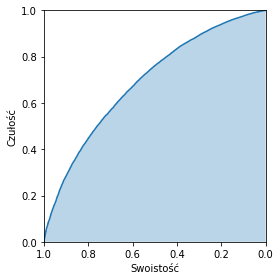

In [ ]:
fpr, tpr, thresholds = roc_curve(y, logit_reg.predict_proba(X)[:,0], 
                                 pos_label='default')
roc_df = pd.DataFrame({'recall': tpr, 'specificity': 1 - fpr})

ax = roc_df.plot(x='specificity', y='recall', figsize=(4, 4), legend=False)
ax.set_ylim(0, 1)
ax.set_xlim(1, 0)
# ax.plot((1, 0), (0, 1))
ax.set_xlabel('Swoistość')
ax.set_ylabel('Czułość')
ax.fill_between(roc_df.specificity, 0, roc_df.recall, alpha=0.3)


plt.tight_layout()
plt.show()

# Strategie dla niezbilansowanych danych
## Undersampling
> Uzyskiwane wyniki są inne niż w R, ale równoważne. Wyniki bazujące na modelu mają zbliżoną wielkość.

In [ ]:
full_train_set = pd.read_csv(FULL_TRAIN_SET_CSV)
print(full_train_set.shape)

(119987, 19)


In [ ]:
print('Odsetek kredytów w klasie default: ', 
print(      100 * np.mean(full_train_set.outcome == 'default')))

18.894546909248504
Odsetek kredytów w klasie default:  None


In [ ]:
predictors = ['payment_inc_ratio', 'purpose_', 'home_', 'emp_len_', 
              'dti', 'revol_bal', 'revol_util']
outcome = 'outcome'
X = pd.get_dummies(full_train_set[predictors], prefix='', prefix_sep='', 
                   drop_first=True)
y = full_train_set[outcome]

full_model = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
full_model.fit(X, y)
print('Odsetek kredytów przewidzianych przez model do klasy default: ', 
print(      100 * np.mean(full_model.predict(X) == 'default')))

0.8650937184861693
Odsetek kredytów przewidzianych przez model do klasy default:  None


In [ ]:
(np.mean(full_train_set.outcome == 'default') / 
 np.mean(full_model.predict(X) == 'default'))

21.84104046242775

## Oversampling i zwiększenie/obniżenie wag

In [ ]:
default_wt = 1 / np.mean(full_train_set.outcome == 'default')
wt = [default_wt if outcome == 'default' else 1 for outcome in full_train_set.outcome]

full_model = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
full_model.fit(X, y, wt)
print('Odsetek kredytów przewidzianych przez model do klasy default (ważony): ', 
print(      100 * np.mean(full_model.predict(X) == 'default')))

61.64084442481269
Odsetek kredytów przewidzianych przez model do klasy default (ważony):  None


## Generowanie danych
Pakiet _imbalanced-learn_ zawiera implementację algorytmu _SMOTE_ i podobnych. 

In [ ]:
X_resampled, y_resampled = SMOTE().fit_resample(X, y)
print('Odsetek kredytów w klasie default (SMOTE): ', 
      100 * np.mean(y_resampled == 'default'))

full_model = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
full_model.fit(X_resampled, y_resampled)
print('Odsetek kredytów przewidzianych przez model do klasy default (SMOTE): ', 
      100 * np.mean(full_model.predict(X) == 'default'))


X_resampled, y_resampled = ADASYN().fit_resample(X, y)
print('Odsetek kredytów w klasie default (ADASYN): ', 
      100 * np.mean(y_resampled == 'default'))

full_model = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
full_model.fit(X_resampled, y_resampled)
print('Odsetek kredytów przewidzianych przez model do klasy default (ADASYN): ', 
print(      100 * np.mean(full_model.predict(X) == 'default')))

## Badanie prognozy

In [ ]:
loan3000 = pd.read_csv(LOAN3000_CSV)

predictors = ['borrower_score', 'payment_inc_ratio']
outcome = 'outcome'

X = loan3000[predictors]
y = loan3000[outcome]

loan_tree = DecisionTreeClassifier(random_state=1, criterion='entropy', 
                                   min_impurity_decrease=0.003)
loan_tree.fit(X, y)

loan_lda = LinearDiscriminantAnalysis()
loan_lda.fit(X, y)

logit_reg = LogisticRegression(penalty="l2", solver='liblinear')
logit_reg.fit(X, y)


## model
gam = LinearGAM(s(0) + s(1))
print(gam.gridsearch(X.values, [1 if yi == 'default' else 0 for yi in y]))

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + intercept, 
   tol=0.0001, verbose=False)


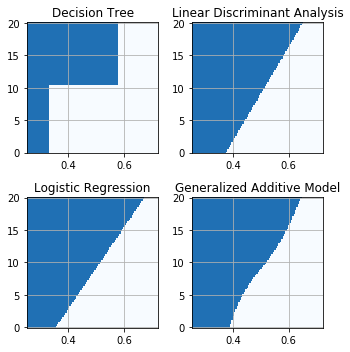

In [ ]:
models = {
    'Decision Tree': loan_tree,
    'Linear Discriminant Analysis': loan_lda,
    'Logistic Regression': logit_reg,
    'Generalized Additive Model': gam,
}

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(5, 5))

xvalues = np.arange(0.25, 0.73, 0.005)
yvalues = np.arange(-0.1, 20.1, 0.1)
xx, yy = np.meshgrid(xvalues, yvalues)
X = np.c_[xx.ravel(), yy.ravel()]

boundary = {}

for n, (title, model) in enumerate(models.items()):
    ax = axes[n // 2, n % 2]
    predict = model.predict(X)
    if 'Generalized' in title:
        Z = np.array([1 if z > 0.5 else 0 for z in predict])
    else:
        
        Z = np.array([1 if z == 'default' else 0 for z in predict])
    Z = Z.reshape(xx.shape)
    boundary[title] = yvalues[np.argmax(Z > 0, axis=0)]
    boundary[title][Z[-1,:] == 0] = yvalues[-1]

    c = ax.pcolormesh(xx, yy, Z, cmap='Blues', vmin=0.1, vmax=1.3)
    ax.set_title(title)
    ax.grid(True)

plt.tight_layout()
plt.show()

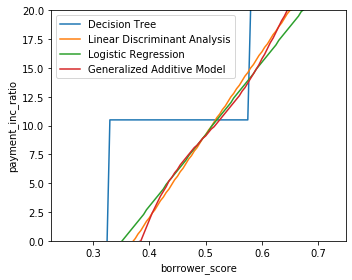

In [ ]:
boundary['borrower_score'] = xvalues
boundaries = pd.DataFrame(boundary)

fig, ax = plt.subplots(figsize=(5, 4))
boundaries.plot(x='borrower_score', ax=ax)
ax.set_ylabel('payment_inc_ratio')
ax.set_ylim(0, 20)


plt.tight_layout()
plt.show()